In [25]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=0, which="LM", return_eigenvectors=False
                )
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
            candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
            candidates.append(candidate)

    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=0, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [4]:
import kwant
import tinyarray
import numpy as np
import scipy as spi

import matplotlib.pyplot as plt 
import matplotlib.colors as colors

In [13]:
tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

phi = 10

tau_ysigma_y = tau_y@sigma_y
print('Keselman:')
keselman_delta = spi.linalg.expm(1j*phi*tau_z)@tau_ysigma_y

tau_xsigma_y = tau_x@sigma_y
print('Kristof:')
kristof_delta = np.real(np.exp(1j*phi))*tau_ysigma_y + np.imag(np.exp(1j*phi))*tau_xsigma_y

print(keselman_delta - kristof_delta)

Keselman:
Kristof:
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [160]:
## function for phase-on-delta implementation

#finite implementation
# a = 6.479 A from http://www.ioffe.ru/SVA/NSM/Semicond/InSb/basic.html
# energies in units of meV, lengths in units of A, mass in units of free electron mass 9.11e-31 kg

def make_system(N_x, W, t, v, mu, B, delta, k, phi):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #### Define the scattering region. ####
    syst[(lat(x) for x in range(1, N_x + 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(x) for x in range(N_x + W + 1, 2*N_x+W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    
    
    syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [138]:
## function for phase-on-delta implementation

#infinite implementation

def make_system(W=10, t=1, nu=0.5, mu=0.5, delta=0.5, B=1, k=1, phi=0):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    
    syst[(lat(0), lat(1))] = -k*spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[(lat(W), lat(W+1))] = -k*(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>1:
        syst[((lat(x), lat(x+1)) for x in range(1, W))] = -t*tau_z - 1j*nu*tau_z@sigma_y 
    
    
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [14]:
## function for phase-on-delta implementation

#infinite implementation (transparency changed to mismatched chemical potential)

def make_system_mu(W=10, t=1, nu=0.5, mu=0.5, mu_lead0=0.5, mu_lead1=0.5, delta=0.5, B=1, phi=0):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu_lead0)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu_lead1)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu_lead0)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu_lead1)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

[[ 1.5+0.j   1. +0.j   0. +0.j  -0.5+0.j   0. -1.j   0. -0.5j  0. +0.j
   0. +0.j ]
 [ 1. +0.j   1.5+0.j   0.5+0.j   0. +0.j   0. +0.5j  0. -1.j   0. +0.j
   0. +0.j ]
 [ 0. +0.j   0.5+0.j  -1.5+0.j  -1. +0.j   0. +0.j   0. +0.j   0. -1.j
   0. -0.5j]
 [-0.5+0.j   0. +0.j  -1. +0.j  -1.5+0.j   0. +0.j   0. +0.j   0. +0.5j
   0. -1.j ]
 [ 0. +1.j   0. -0.5j  0. -0.j   0. -0.j   1.5+0.j   1. +0.j   0. +0.j
  -0.5+0.j ]
 [ 0. +0.5j  0. +1.j   0. -0.j   0. -0.j   1. +0.j   1.5+0.j   0.5+0.j
   0. +0.j ]
 [ 0. -0.j   0. -0.j   0. +1.j   0. -0.5j  0. +0.j   0.5+0.j  -1.5+0.j
  -1. +0.j ]
 [ 0. -0.j   0. -0.j   0. +0.5j  0. +1.j  -0.5+0.j   0. +0.j  -1. +0.j
  -1.5+0.j ]]


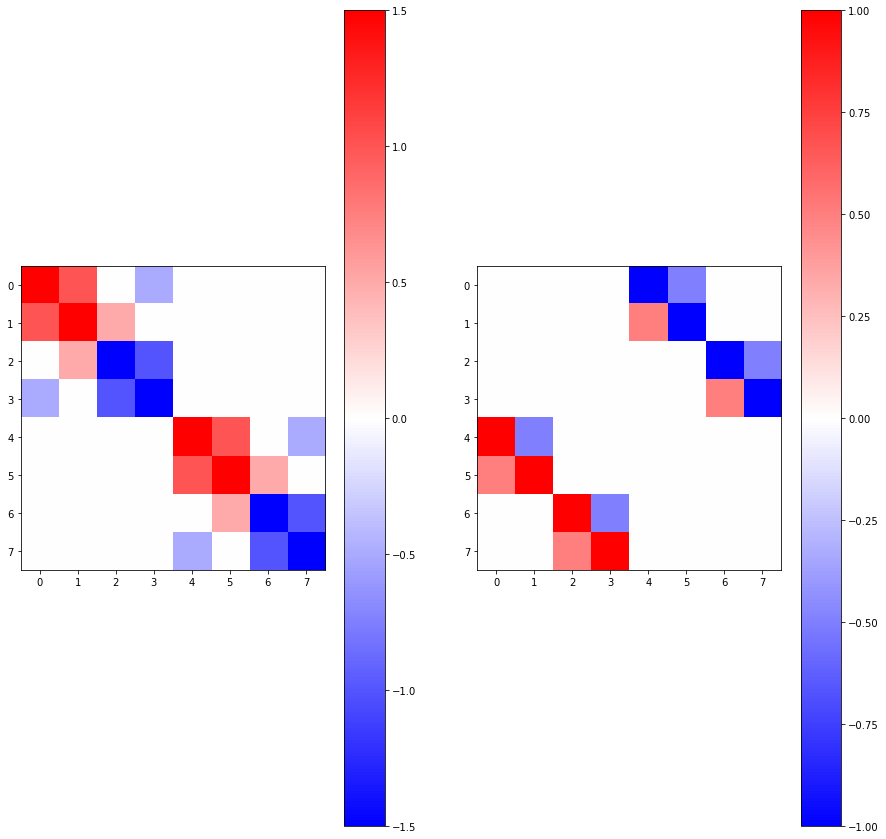

In [15]:
syst = make_system_mu(W=0, mu=0, mu_lead0=0.5, mu_lead1=0.5, phi=np.pi)
#kwant.plot(syst)
ham_bdg = syst.hamiltonian_submatrix()

norm1 = colors.TwoSlopeNorm(vcenter=0)
norm2 = colors.TwoSlopeNorm(vcenter=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
im1 = ax1.imshow(np.real(ham_bdg), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(ham_bdg), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)
print(ham_bdg)

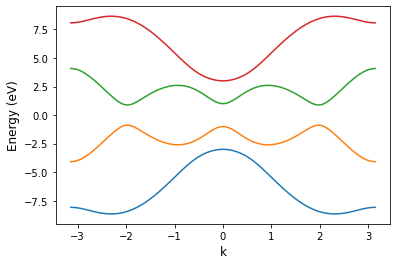

In [19]:
syst = make_system_mu(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1., B=2.)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,101)
energies=[bands(k) for k in momenta]

x=np.array(energies)
en=(x)
#plt.ylim(-2,2)

plt.plot(momenta, en)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

## Boundstate algo

In [20]:
def phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., k=0.1, delta=1.):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 4*np.pi, 21):
        print(i)
        syst = make_system(W=W, B=B, t=t, nu=nu, mu=mu, k=k, delta=delta, phi=i)
        energies, wavefunctions = find_boundstates(syst, -0.0005, 0.0005, rtol=1e-5)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [192]:
e_array00, psi_array00 = phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., k=0.1, delta=1.)
print(e_array00)

0.0
[-0.00034409  0.00034409]
0.6283185307179586
[-0.00032722  0.00032722]
1.2566370614359172
[-0.00027829  0.00027829]
1.8849555921538759
[-0.00020214  0.00020214]
2.5132741228718345
[-0.00010625  0.00010625]
3.141592653589793
[4.76067245e-16 4.76067245e-16]
3.7699111843077517
[-0.00010625  0.00010625]
4.39822971502571
[-0.00020214  0.00020214]
5.026548245743669
[-0.00027829  0.00027829]
5.654866776461628
[-0.00032722  0.00032722]
6.283185307179586
[-0.00034409  0.00034409]
6.911503837897545
[-0.00032722  0.00032722]
7.5398223686155035
[-0.00027829  0.00027829]
8.168140899333462
[-0.00020214  0.00020214]
8.79645943005142
[-0.00010625  0.00010625]
9.42477796076938
[4.76046069e-16 4.76046069e-16]
10.053096491487338
[-0.00010625  0.00010625]
10.681415022205297
[-0.00020214  0.00020214]
11.309733552923255
[-0.00027829  0.00027829]
11.938052083641214
[-0.00032722  0.00032722]
12.566370614359172
[-0.00034409  0.00034409]
[array([-0.00034409,  0.00034409]), array([-0.00032722,  0.00032722]),

Text(0.5, 1.0, '$W=0, B=2., t=1.5, \\nu=2., \\mu=0., k=0.1, \\Delta=1.$')

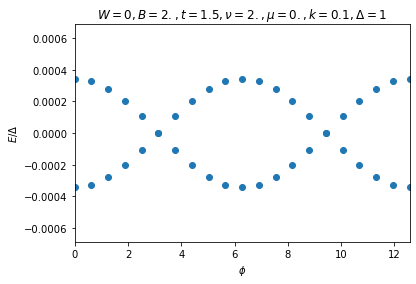

In [193]:
ex = []
ey = []
#ex1 = []
#ey1 = []
#ex2 = []
#ey2 = []
for i in range(len(e_array00)):
    for j in range(len(e_array00[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array00[i][j])
    '''for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])'''
plt.scatter(ex, ey)
#plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
#plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
plt.xlim(0, 4*np.pi)
plt.ylim(2*min(ey), 2*max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$W=0, B=2., t=1.5, \nu=2., \mu=0., k=0.1, \Delta=1.$')
#plt.legend()

In [17]:
e_array, psi_array = phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., k=1., delta=1.)
#e_array1, psi_array1 = phi_scan_alt(tauv=2./3., Lv=3)
#e_array2, psi_array2 = phi_scan_alt(tauv=1./3., Lv=3)
print(e_array)
#print(e_array1)
#print(e_array2)

0.0
[-0.82484417 -0.29299719  0.29299719  0.82484417]
0.6283185307179586
[-0.81822721 -0.28151553  0.28151553  0.81822721]
1.2566370614359172
[-0.81081246 -0.24393107  0.24393107  0.81081246]
1.8849555921538759
[-0.81975648 -0.17841903  0.17841903  0.81975648]
2.5132741228718345
[-0.83966901 -0.09322425  0.09322425  0.83966901]
3.141592653589793
[-8.49527471e-01  3.35668993e-16  3.35668993e-16  8.49527471e-01]
3.7699111843077517
[-0.83966901 -0.09322425  0.09322425  0.83966901]
4.39822971502571
[-0.81975648 -0.17841903  0.17841903  0.81975648]
5.026548245743669
[-0.81081246 -0.24393107  0.24393107  0.81081246]
5.654866776461628
[-0.81822721 -0.28151553  0.28151553  0.81822721]
6.283185307179586
[-0.82484417 -0.29299719  0.29299719  0.82484417]
6.911503837897545
[-0.81822721 -0.28151553  0.28151553  0.81822721]
7.5398223686155035
[-0.81081246 -0.24393107  0.24393107  0.81081246]
8.168140899333462
[-0.81975648 -0.17841903  0.17841903  0.81975648]
8.79645943005142
[-0.83966901 -0.09322425

Text(0.5, 1.0, '$W=0, B=2., t=1.5, \\nu=2., \\mu=0., k=1, \\Delta=1.$')

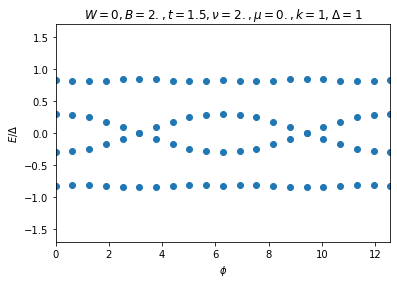

In [18]:
ex = []
ey = []
#ex1 = []
#ey1 = []
#ex2 = []
#ey2 = []
for i in range(len(e_array)):
    for j in range(len(e_array[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array[i][j])
    '''for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])'''
plt.scatter(ex, ey)
#plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
#plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
plt.xlim(0, 4*np.pi)
plt.ylim(2*min(ey), 2*max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$W=0, B=2., t=1.5, \nu=2., \mu=0., k=1, \Delta=1.$')
#plt.legend()

In [20]:
e_array1, psi_array1 = phi_scan(W=1, B=2., t=1.5, nu=2., mu=0., k=1, delta=1.)
print(e_array1)
e_array2, psi_array2 = phi_scan(W=2, B=2., t=1.5, nu=2., mu=0., k=1, delta=1.)
print(e_array2)
e_array3, psi_array3 = phi_scan(W=4, B=2., t=1.5, nu=2., mu=0., k=1, delta=1.)
print(e_array3)

0.0
[-0.66311949 -0.13188976  0.13188976  0.66311949]
0.6283185307179586
[-0.65640929 -0.12732788  0.12732788  0.65640929]
1.2566370614359172
[-0.64173263 -0.11242026  0.11242026  0.64173263]
1.8849555921538759
[-0.62983249 -0.08510142  0.08510142  0.62983249]
2.5132741228718345
[-0.62587331 -0.04602365  0.04602365  0.62587331]
3.141592653589793
[-6.25852983e-01  3.68628739e-16  3.68628739e-16  6.25852983e-01]
3.7699111843077517
[-0.62587331 -0.04602365  0.04602365  0.62587331]
4.39822971502571
[-0.62983249 -0.08510142  0.08510142  0.62983249]
5.026548245743669
[-0.64173263 -0.11242026  0.11242026  0.64173263]
5.654866776461628
[-0.65640929 -0.12732788  0.12732788  0.65640929]
6.283185307179586
[-0.66311949 -0.13188976  0.13188976  0.66311949]
6.911503837897545
[-0.65640929 -0.12732788  0.12732788  0.65640929]
7.5398223686155035
[-0.64173263 -0.11242026  0.11242026  0.64173263]
8.168140899333462
[-0.62983249 -0.08510142  0.08510142  0.62983249]
8.79645943005142
[-0.62587331 -0.04602365

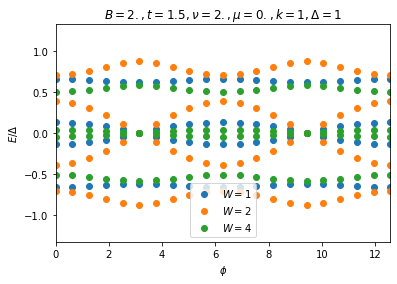

In [21]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array1)):
    for j in range(len(e_array[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array2[i][j])
    for j in range(len(e_array3[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array3[i][j])
plt.scatter(ex, ey, label=r'$W=1$')
plt.scatter(ex1, ey1, label=r'$W=2$')
plt.scatter(ex2, ey2, label=r'$W=4$')
plt.xlim(0, 4*np.pi)
plt.ylim(2*min(ey), 2*max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$B=2., t=1.5, \nu=2., \mu=0., k=1, \Delta=1.$')
plt.legend()
plt.savefig('./Keselman.png', dpi=300)

In [42]:
e_array5, psi_array5 = phi_scan(W=10, B=2., t=1.5, nu=2., mu=0., k=1, delta=1.)
print(e_array5)

0.0
[-0.64739524 -0.38696189 -0.0966444   0.0966444   0.38696189  0.64739524]
0.6283185307179586
[-0.63993332 -0.39377573 -0.09105743  0.09105743  0.39377573  0.63993332]
1.2566370614359172
[-0.61933943 -0.41268634 -0.07570561  0.07570561  0.41268634  0.61933943]
1.8849555921538759
[-0.58976513 -0.44022287 -0.05361445  0.05361445  0.44022287  0.58976513]
2.5132741228718345
[-0.55628904 -0.47209316 -0.02765862  0.02765862  0.47209316  0.55628904]
3.141592653589793
[-5.33238910e-01 -4.94540683e-01  3.35668993e-16  3.35668993e-16
  4.94540683e-01  5.33238910e-01]
3.7699111843077517
[-0.55628904 -0.47209316 -0.02765862  0.02765862  0.47209316  0.55628904]
4.39822971502571
[-0.58976513 -0.44022287 -0.05361445  0.05361445  0.44022287  0.58976513]
5.026548245743669
[-0.61933943 -0.41268634 -0.07570561  0.07570561  0.41268634  0.61933943]
5.654866776461628
[-0.63993332 -0.39377573 -0.09105743  0.09105743  0.39377573  0.63993332]
6.283185307179586
[-0.64739524 -0.38696189 -0.0966444   0.0966444

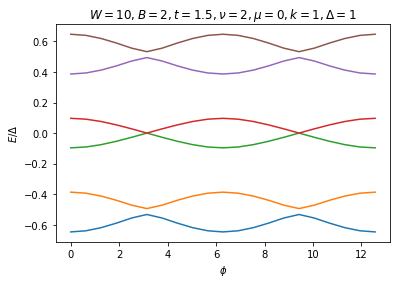

In [47]:
plt.plot(np.linspace(0, 4*np.pi, 21), e_array5)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$W=10, B=2, t=1.5, \nu=2, \mu=0, k=1, \Delta=1$')
plt.savefig('./Keselman_W_equal_10.png', dpi=300)

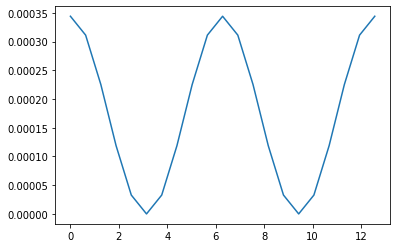

In [132]:
ex_inte = np.linspace(0, 4*np.pi, 21)
ey_inte = []
i=1
for ey in e_array:
    if np.abs(ey[0]) < 1e-14:
        i+=1
        ey_inte.append(ey[i%2])
    else:
        ey_inte.append(ey[i%2])

ey_inte = np.array(ey_inte)
ey_inte2 = np.cos(ex_inte/2.)*ey_inte
plt.plot(ex_inte, ey_inte2)

In [19]:
from scipy import integrate as inte
scipy.__version__

'1.7.0'

In [100]:
def integral_approximation(func, a, b, N):
    bottom = (b-a)/N
    x_arr = np.linspace(a, b, N+1)
    y_arr = []
    for x in x_arr:
        y_arr.append(func(x))
    area = 0.
    for i in range(N):
        area+=(y_arr[i]+y_arr[i+1])*bottom/2.
    return area

def test_func(x):
    return x**2.



print(integral_approximation(test_func, 0, 1, 1000))
print(spi.integrate.quad(test_func, 0, 1))

0.33333349999999984
(0.33333333333333337, 3.700743415417189e-15)


## E_M vs W

In [33]:
def W_scan(B=2., t=1.5, nu=2., mu=0., k=0.1, delta=1., phi=0.):
    energy_arrays = []
    wavefunc_arrays = []
    for i in range(0, 11):
        print(i)
        syst = make_system(W=i, B=B, t=t, nu=nu, mu=mu, k=k, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -1, 1, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [34]:
e_array4, psi_array4 = W_scan(B=2., t=1.5, nu=2., mu=0., k=1., delta=1., phi=0.)
print(e_array4)

0
[-0.82484417 -0.29299719  0.29299719  0.82484417]
1
[-0.66311949 -0.13188976  0.13188976  0.66311949]
2
[-0.71041241 -0.3928608   0.3928608   0.71041241]
3
[-0.4038505  -0.11468791  0.11468791  0.4038505 ]
4
[-0.50601904 -0.04231066  0.04231066  0.50601904]
5
[-0.4744818  -0.18080397  0.18080397  0.4744818 ]
6
[-0.22595203  0.22595203]
7
[-0.81278036 -0.45317019 -0.08892865  0.08892865  0.45317019  0.81278036]
8
[-0.87859587 -0.31684994 -0.14175345  0.14175345  0.31684994  0.87859587]
9
[-0.83222602 -0.2584667  -0.1499279   0.1499279   0.2584667   0.83222602]
10
[-0.64739524 -0.38696189 -0.0966444   0.0966444   0.38696189  0.64739524]
[array([-0.82484417, -0.29299719,  0.29299719,  0.82484417]), array([-0.66311949, -0.13188976,  0.13188976,  0.66311949]), array([-0.71041241, -0.3928608 ,  0.3928608 ,  0.71041241]), array([-0.4038505 , -0.11468791,  0.11468791,  0.4038505 ]), array([-0.50601904, -0.04231066,  0.04231066,  0.50601904]), array([-0.4744818 , -0.18080397,  0.18080397,  0.

In [48]:
e_array6, psi_array6 = W_scan(B=2., t=1.5, nu=2., mu=0., k=1., delta=1., phi=np.pi)
print(e_array6)

0
[-8.49527471e-01  3.42607887e-16  3.42607887e-16  8.49527471e-01]
1
[-6.25852983e-01  3.66026653e-16  3.66026653e-16  6.25852983e-01]
2
[-8.77686763e-01 -1.47278023e-15 -1.47278023e-15  8.77686763e-01]
3
[-4.78025420e-01  2.70616862e-16  2.70616862e-16  4.78025420e-01]
4
[-5.86997485e-01  3.53883589e-16  3.53883589e-16  5.86997485e-01]
5
[-5.64473338e-01 -5.81999726e-16 -5.81999726e-16  5.64473338e-01]
6
[-3.60694983e-01  3.18321758e-16  3.18321758e-16  3.60694983e-01]
7
[-6.88141169e-01 -5.54507201e-01  3.51281504e-16  3.51281504e-16
  5.54507201e-01  6.88141169e-01]
8
[-7.91202718e-01 -3.85725321e-01  3.32199546e-16  3.32199546e-16
  3.85725321e-01  7.91202718e-01]
9
[-7.56252395e-01 -3.34551759e-01  3.60822483e-16  3.60822483e-16
  3.34551759e-01  7.56252395e-01]
10
[-5.33238910e-01 -4.94540683e-01  3.35668993e-16  3.35668993e-16
  4.94540683e-01  5.33238910e-01]
[array([-8.49527471e-01,  3.42607887e-16,  3.42607887e-16,  8.49527471e-01]), array([-6.25852983e-01,  3.66026653e-16, 

Text(0.5, 1.0, '$B=2., t=1.5, \\nu=2., \\mu=0., k=1, \\Delta=1.$')

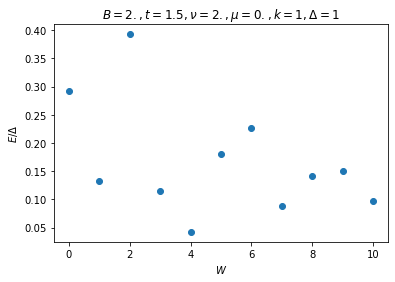

In [57]:
E_M = []
W = np.arange(0, 11)

for i in W:
    E_M.append(np.min(np.abs(e_array4[i])))
    
plt.scatter(W, E_M)
plt.xlabel(r'$W$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$B=2., t=1.5, \nu=2., \mu=0., k=1, \Delta=1.$')

## Mismatched chemical potential

In [26]:
def phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., delta=1., mu_lead=0.5, e_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 4*np.pi, 21):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=mu, mu_lead0=mu_lead, mu_lead1=mu_lead, delta=delta, phi=i)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [27]:
e_array_neg_delta, _ = phi_scan(W=1, B=2., t=1.5, mu=0., mu_lead=0., delta=-1.)
print(e_array_neg_delta)

0.0
[-0.66311949 -0.13188976  0.13188976  0.66311949]
0.6283185307179586
[-0.65640929 -0.12732788  0.12732788  0.65640929]
1.2566370614359172
[-0.64173263 -0.11242026  0.11242026  0.64173263]
1.8849555921538759
[-0.62983249 -0.08510142  0.08510142  0.62983249]
2.5132741228718345
[-0.62587331 -0.04602365  0.04602365  0.62587331]
3.141592653589793
[-6.25852983e-01  3.75567633e-16  3.75567633e-16  6.25852983e-01]
3.7699111843077517
[-0.62587331 -0.04602365  0.04602365  0.62587331]
4.39822971502571
[-0.62983249 -0.08510142  0.08510142  0.62983249]
5.026548245743669
[-0.64173263 -0.11242026  0.11242026  0.64173263]
5.654866776461628
[-0.65640929 -0.12732788  0.12732788  0.65640929]
6.283185307179586
[-0.66311949 -0.13188976  0.13188976  0.66311949]
6.911503837897545
[-0.65640929 -0.12732788  0.12732788  0.65640929]
7.5398223686155035
[-0.64173263 -0.11242026  0.11242026  0.64173263]
8.168140899333462
[-0.62983249 -0.08510142  0.08510142  0.62983249]
8.79645943005142
[-0.62587331 -0.04602365

In [28]:
e_array_pos_delta, _ = phi_scan(W=1, B=2., t=1.5, mu=0., mu_lead=0., delta=1.)
print(e_array_pos_delta)

0.0
[-0.66311949 -0.13188976  0.13188976  0.66311949]
0.6283185307179586
[-0.65640929 -0.12732788  0.12732788  0.65640929]
1.2566370614359172
[-0.64173263 -0.11242026  0.11242026  0.64173263]
1.8849555921538759
[-0.62983249 -0.08510142  0.08510142  0.62983249]
2.5132741228718345
[-0.62587331 -0.04602365  0.04602365  0.62587331]
3.141592653589793
[-6.25852983e-01  3.67761377e-16  3.67761377e-16  6.25852983e-01]
3.7699111843077517
[-0.62587331 -0.04602365  0.04602365  0.62587331]
4.39822971502571
[-0.62983249 -0.08510142  0.08510142  0.62983249]
5.026548245743669
[-0.64173263 -0.11242026  0.11242026  0.64173263]
5.654866776461628
[-0.65640929 -0.12732788  0.12732788  0.65640929]
6.283185307179586
[-0.66311949 -0.13188976  0.13188976  0.66311949]
6.911503837897545
[-0.65640929 -0.12732788  0.12732788  0.65640929]
7.5398223686155035
[-0.64173263 -0.11242026  0.11242026  0.64173263]
8.168140899333462
[-0.62983249 -0.08510142  0.08510142  0.62983249]
8.79645943005142
[-0.62587331 -0.04602365

In [86]:
### no mismatched chemical potential
e_array7, psi_array7 = phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., mu_lead=0., delta=1.)
print(e_array7)

0.0
[-0.82484417 -0.29299719  0.29299719  0.82484417]
0.6283185307179586
[-0.81822721 -0.28151553  0.28151553  0.81822721]
1.2566370614359172
[-0.81081246 -0.24393107  0.24393107  0.81081246]
1.8849555921538759
[-0.81975648 -0.17841903  0.17841903  0.81975648]
2.5132741228718345
[-0.83966901 -0.09322425  0.09322425  0.83966901]
3.141592653589793
[-8.49527471e-01  3.44342610e-16  3.44342610e-16  8.49527471e-01]
3.7699111843077517
[-0.83966901 -0.09322425  0.09322425  0.83966901]
4.39822971502571
[-0.81975648 -0.17841903  0.17841903  0.81975648]
5.026548245743669
[-0.81081246 -0.24393107  0.24393107  0.81081246]
5.654866776461628
[-0.81822721 -0.28151553  0.28151553  0.81822721]
6.283185307179586
[-0.82484417 -0.29299719  0.29299719  0.82484417]
6.911503837897545
[-0.81822721 -0.28151553  0.28151553  0.81822721]
7.5398223686155035
[-0.81081246 -0.24393107  0.24393107  0.81081246]
8.168140899333462
[-0.81975648 -0.17841903  0.17841903  0.81975648]
8.79645943005142
[-0.83966901 -0.09322425

Text(0.5, 1.0, '$W=0, B=2, t=1.5, \\nu=2, \\mu=0, \\mu_{lead}=0, delta=1$')

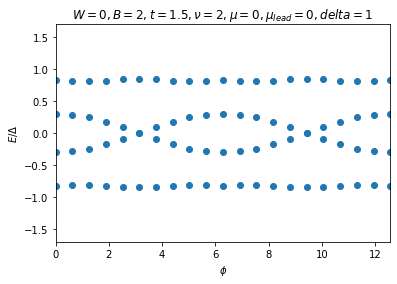

In [89]:
ex = []
ey = []
#ex1 = []
#ey1 = []
#ex2 = []
#ey2 = []
for i in range(len(e_array7)):
    for j in range(len(e_array7[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array7[i][j])
    '''for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])'''
plt.scatter(ex, ey)
#plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
#plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
plt.xlim(0, 4*np.pi)
plt.ylim(2*min(ey), 2*max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$W=0, B=2, t=1.5, \nu=2, \mu=0, \mu_{lead}=0, delta=1$')
#plt.legend()

In [98]:
## higher chemical potential in leads
e_array8, psi_array8 = phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., mu_lead=0.5, delta=1., e_range=2., rtol=1e-1)
print(e_array8)

0.0
[-0.5487787  0.5487787]
0.6283185307179586
[-0.82546024 -0.52119381  0.52119381  0.82546024]
1.2566370614359172
[-0.83838522 -0.43796835  0.43796835  0.83838522]
1.8849555921538759
[-0.86294993 -0.31072845  0.31072845  0.86294993]
2.5132741228718345
[-0.15974112  0.15974112]
3.141592653589793
[4.64905892e-16 4.64905892e-16]
3.7699111843077517
[-0.15974112  0.15974112]
4.39822971502571
[-0.86294993 -0.31072845  0.31072845  0.86294993]
5.026548245743669
[-0.83838522 -0.43796835  0.43796835  0.83838522]
5.654866776461628
[-0.82546024 -0.52119381  0.52119381  0.82546024]
6.283185307179586
[-0.5487787  0.5487787]
6.911503837897545
[-0.82546024 -0.52119381  0.52119381  0.82546024]
7.5398223686155035
[-0.83838522 -0.43796835  0.43796835  0.83838522]
8.168140899333462
[-0.86294993 -0.31072845  0.31072845  0.86294993]
8.79645943005142
[-0.15974112  0.15974112]
9.42477796076938
[4.51028104e-16 4.51028104e-16]
10.053096491487338
[-0.15974112  0.15974112]
10.681415022205297
[-0.86294993 -0.310

Text(0.5, 1.0, '$W=0, B=2, t=1.5, \\nu=2, \\mu=0, \\mu_{lead}=0.5, delta=1$')

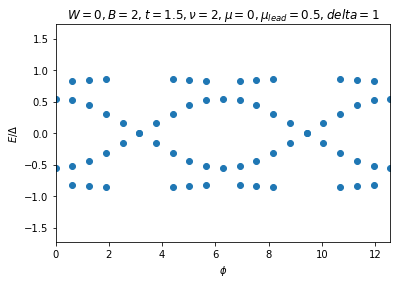

In [99]:
ex = []
ey = []
#ex1 = []
#ey1 = []
#ex2 = []
#ey2 = []
for i in range(len(e_array8)):
    for j in range(len(e_array8[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array8[i][j])
    '''for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])'''
plt.scatter(ex, ey)
#plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
#plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
plt.xlim(0, 4*np.pi)
plt.ylim(2*min(ey), 2*max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$W=0, B=2, t=1.5, \nu=2, \mu=0, \mu_{lead}=0.5, delta=1$')
#plt.legend()

In [96]:
## lower chemical potential in leads
# very expensive, never re-run!!!!
e_array9, psi_array9 = phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., mu_lead=-0.5, delta=1., e_range=1., rtol=1e-3)
print(e_array9)

0.0
[-0.80858214 -0.0203117   0.0203117   0.80858214]
0.6283185307179586
[-0.80096633 -0.0195326   0.0195326   0.80096633]
1.2566370614359172
[-0.79147818 -0.01698253  0.01698253  0.79147818]
1.8849555921538759
[-0.80040263 -0.01247745  0.01247745  0.80040263]
2.5132741228718345
[-0.82589486 -0.00653038  0.00653038  0.82589486]
3.141592653589793
[-8.40567447e-01  2.37038037e-14  2.37038037e-14  8.40567447e-01]
3.7699111843077517
[-0.82589486 -0.00653038  0.00653038  0.82589486]
4.39822971502571
[-0.80040263 -0.01247745  0.01247745  0.80040263]
5.026548245743669
[-0.79147818 -0.01698253  0.01698253  0.79147818]
5.654866776461628
[-0.80096633 -0.0195326   0.0195326   0.80096633]
6.283185307179586
[-0.80858214 -0.0203117   0.0203117   0.80858214]
6.911503837897545
[-0.80096633 -0.0195326   0.0195326   0.80096633]
7.5398223686155035
[-0.79147818 -0.01698253  0.01698253  0.79147818]
8.168140899333462
[-0.80040263 -0.01247745  0.01247745  0.80040263]
8.79645943005142
[-0.82589486 -0.00653038

Text(0.5, 1.0, '$W=0, B=2, t=1.5, \\nu=2, \\mu=0, \\mu_{lead}=-0.5, delta=1$')

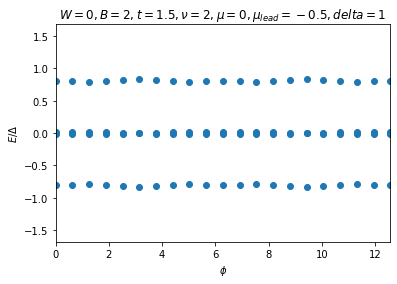

In [102]:
ex = []
ey = []
#ex1 = []
#ey1 = []
#ex2 = []
#ey2 = []
for i in range(len(e_array9)):
    for j in range(len(e_array9[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array9[i][j])
    '''for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])'''
plt.scatter(ex, ey)
#plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
#plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
plt.xlim(0, 4*np.pi)
plt.ylim(2*min(ey), 2*max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$W=0, B=2, t=1.5, \nu=2, \mu=0, \mu_{lead}=-0.5, delta=1$')
#plt.legend()

## E_M vs mu_leads

In [110]:
def mu_scan(W=0, B=2., t=1.5, nu=2., mu=0., delta=1., phi=0., e_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(-5., 5., 101):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=mu, mu_lead0=i, mu_lead1=i, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [129]:
e_array10, psi_array10 = mu_scan(W=0, B=2., t=1.5, nu=2., mu=0., phi=0., delta=1., e_range=1., rtol=1e-1)
print(e_array10)

-5.0
[]
-4.9
[]
-4.8
[]
-4.7
[]
-4.6
[]
-4.5
[]
-4.4
[]
-4.3
[]
-4.2
[]
-4.1
[]
-4.0
[]
-3.9
[]
-3.8
[]
-3.7
[]
-3.5999999999999996
[]
-3.5
[-0.92723442  0.92723442]
-3.4
[-0.84787556  0.84787556]
-3.3
[-0.77128876  0.77128876]
-3.2
[-0.69795419  0.69795419]
-3.0999999999999996
[-0.62841678  0.62841678]
-3.0
[-0.56326839  0.56326839]
-2.9
[-0.50310552  0.50310552]
-2.8
[-0.44845207  0.44845207]
-2.6999999999999997
[-0.39964182  0.39964182]
-2.5999999999999996
[-0.35666973  0.35666973]
-2.5
[-0.31904245  0.31904245]
-2.4
[-0.28567388  0.28567388]
-2.3
[-0.25486129  0.25486129]
-2.1999999999999997
[-0.22434294  0.22434294]
-2.0999999999999996
[-0.19140609  0.19140609]
-2.0
[-0.15301874  0.15301874]
-1.9
[]
-1.7999999999999998
[0.04744007]
-1.6999999999999997
[]
-1.5999999999999996
[]
-1.5
[]
-1.4
[]
-1.2999999999999998
[]
-1.1999999999999997
[-0.32961796  0.32961796]
-1.0999999999999996
[-0.31621196  0.31621196]
-1.0
[-0.28570337  0.28570337]
-0.8999999999999995
[-0.24388747  0.24388747]

Text(0.5, 1.0, '$B=2, t=1.5, \\nu=2, \\mu_{scat}=0, \\Delta=1.$')

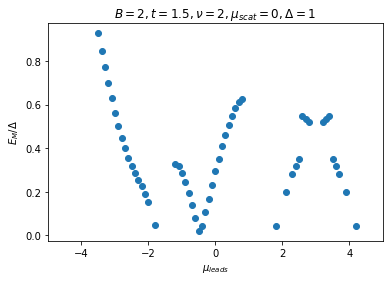

In [130]:
E_M = []
mu_leads = []

for i in range(101):
    if e_array10[i].size!=0:
        E_M.append(np.min(np.abs(e_array10[i])))
        mu_leads.append(np.linspace(-5, 5, 101)[i])
    
plt.scatter(mu_leads, E_M)
plt.xlabel(r'$\mu_{leads}$')
plt.ylabel(r'$E_M/\Delta$')
plt.xlim(-5, 5)
#plt.ylim(0, 0.6)
plt.title(r'$B=2, t=1.5, \nu=2, \mu_{scat}=0, \Delta=1.$')

In [121]:
def mu_scan_all(W=0, B=2., t=1.5, nu=2., delta=1., phi=0., e_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(-5., 5., 101):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=i, mu_lead0=i, mu_lead1=i, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [131]:
e_array11, psi_array11 = mu_scan_all(W=0, B=2., t=1.5, nu=2., phi=0., delta=1., e_range=1., rtol=1e-1)
print(e_array11)

-5.0
[]
-4.9
[]
-4.8
[]
-4.7
[]
-4.6
[]
-4.5
[]
-4.4
[]
-4.3
[]
-4.2
[]
-4.1
[]
-4.0
[]
-3.9
[]
-3.8
[]
-3.7
[]
-3.5999999999999996
[]
-3.5
[-0.92723442  0.92723442]
-3.4
[-0.84787556  0.84787556]
-3.3
[-0.77128876  0.77128876]
-3.2
[-0.69795419  0.69795419]
-3.0999999999999996
[-0.62841678  0.62841678]
-3.0
[-0.56326839  0.56326839]
-2.9
[-0.50310552  0.50310552]
-2.8
[-0.44845207  0.44845207]
-2.6999999999999997
[-0.39964182  0.39964182]
-2.5999999999999996
[-0.35666973  0.35666973]
-2.5
[-0.31904245  0.31904245]
-2.4
[-0.28567388  0.28567388]
-2.3
[-0.25486129  0.25486129]
-2.1999999999999997
[-0.22434294  0.22434294]
-2.0999999999999996
[-0.19140609  0.19140609]
-2.0
[-0.15301874  0.15301874]
-1.9
[]
-1.7999999999999998
[0.04744007]
-1.6999999999999997
[]
-1.5999999999999996
[]
-1.5
[]
-1.4
[]
-1.2999999999999998
[]
-1.1999999999999997
[-0.32961796  0.32961796]
-1.0999999999999996
[-0.31621196  0.31621196]
-1.0
[-0.28570337  0.28570337]
-0.8999999999999995
[-0.24388747  0.24388747]

Text(0.5, 1.0, '$B=2, t=1.5, \\nu=2, \\Delta=1.$')

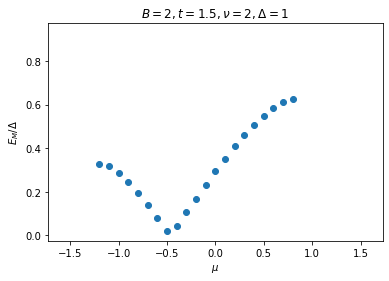

In [136]:
E_M = []
mu_leads = []

for i in range(101):
    if e_array11[i].size!=0:
        E_M.append(np.min(np.abs(e_array11[i])))
        mu_leads.append(np.linspace(-5, 5, 101)[i])
    
plt.scatter(mu_leads, E_M)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$E_M/\Delta$')
plt.xlim(-1.73, 1.73)
#plt.ylim(0, 0.6)
plt.title(r'$B=2, t=1.5, \nu=2, \Delta=1.$')

In [133]:
def mu_scan_half(W=0, B=2., t=1.5, nu=2., delta=1., phi=0., e_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(-5., 5., 101):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=0., mu_lead0=0., mu_lead1=i, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [134]:
e_array12, psi_array12 = mu_scan_half(W=0, B=2., t=1.5, nu=2., phi=0., delta=1., e_range=1., rtol=1e-1)
print(e_array12)

-5.0
[6.24500451e-16]
-4.9
[2.86576318e-15]
-4.8
[1.17267307e-15]
-4.7
[1.94289029e-15]
-4.6
[2.22044605e-16]
-4.5
[6.45317133e-16]
-4.4
[-2.63677968e-16]
-4.3
[1.2490009e-16]
-4.2
[1.74166237e-15]
-4.1
[-3.95516953e-16]
-4.0
[2.08166817e-17]
-3.9
[2.21350716e-15]
-3.8
[-5.20417043e-16]
-3.7
[-9.15933995e-16]
-3.5999999999999996
[2.49800181e-16]
-3.5
[1.34614542e-15]
-3.4
[-2.8449465e-16]
-3.3
[5.55111512e-16]
-3.2
[5.34294831e-16]
-3.0999999999999996
[-1.73472348e-16]
-3.0
[6.17561557e-16]
-2.9
[-6.9388939e-18]
-2.8
[1.72778458e-15]
-2.6999999999999997
[-8.32667268e-17]
-2.5999999999999996
[2.07472928e-15]
-2.5
[1.17267307e-15]
-2.4
[-2.91433544e-16]
-2.3
[5.96744876e-16]
-2.1999999999999997
[-1.15185639e-15]
-2.0999999999999996
[1.97758476e-15]
-2.0
[1.06165077e-15]
-1.9
[9.57567359e-16]
-1.7999999999999998
[1.06858966e-15]
-1.6999999999999997
[]
-1.5999999999999996
[]
-1.5
[-0.13282409  0.13282409]
-1.4
[-0.1256469  0.1256469]
-1.2999999999999998
[-0.1069135  0.1069135]
-1.199999999

Text(0.5, 1.0, '$B=2, t=1.5, \\nu=2, \\Delta=1.$')

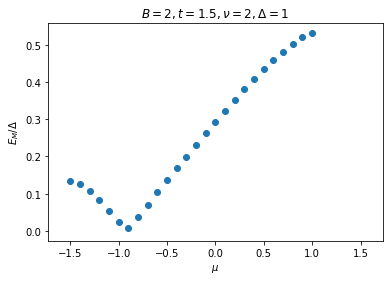

In [137]:
E_M = []
mu_leads = []

for i in range(101):
    if e_array12[i].size!=0:
        E_M.append(np.min(np.abs(e_array12[i])))
        mu_leads.append(np.linspace(-5, 5, 101)[i])
    
plt.scatter(mu_leads, E_M)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$E_M/\Delta$')
plt.xlim(-1.73, 1.73)
#plt.ylim(0, 0.6)
plt.title(r'$B=2, t=1.5, \nu=2, \Delta=1.$')

## Looking for gap opening for mismatched chemical potential

In [146]:
def phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., delta=1., mu_lead=0.5, e_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 4*np.pi, 21):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=mu, mu_lead0=mu, mu_lead1=mu_lead, delta=delta, phi=i)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [147]:
e_array14, psi_array14 = phi_scan()
print(e_array14)

0.0
[-0.82169855 -0.43346384  0.43346384  0.82169855]
0.6283185307179586
[-0.81808682 -0.41468338  0.41468338  0.81808682]
1.2566370614359172
[-0.82038298 -0.35455764  0.35455764  0.82038298]
1.8849555921538759
[-0.84088838 -0.25523563  0.25523563  0.84088838]
2.5132741228718345
[-0.13207879  0.13207879]
3.141592653589793
[-5.12610787e-16 -5.12610787e-16]
3.7699111843077517
[-0.13207879  0.13207879]
4.39822971502571
[-0.84088838 -0.25523563  0.25523563  0.84088838]
5.026548245743669
[-0.82038298 -0.35455764  0.35455764  0.82038298]
5.654866776461628
[-0.81808682 -0.41468338  0.41468338  0.81808682]
6.283185307179586
[-0.82169855 -0.43346384  0.43346384  0.82169855]
6.911503837897545
[-0.81808682 -0.41468338  0.41468338  0.81808682]
7.5398223686155035
[-0.82038298 -0.35455764  0.35455764  0.82038298]
8.168140899333462
[-0.84088838 -0.25523563  0.25523563  0.84088838]
8.79645943005142
[-0.13207879  0.13207879]
9.42477796076938
[-5.23019128e-16 -5.23019128e-16]
10.053096491487338
[-0.1320

Text(0.5, 1.0, '$W=0, B=2, t=1.5, \\nu=2, \\mu=0, \\mu_{lead0}=0, \\mu_{lead1}=0.5, delta=1$')

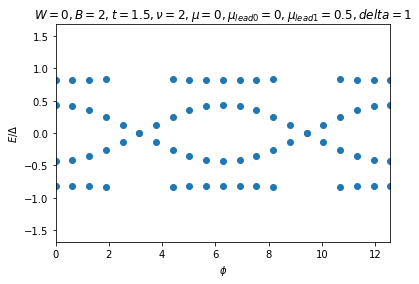

In [148]:
ex = []
ey = []
#ex1 = []
#ey1 = []
#ex2 = []
#ey2 = []
for i in range(len(e_array14)):
    for j in range(len(e_array14[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array14[i][j])
    '''for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])'''
plt.scatter(ex, ey)
#plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
#plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
plt.xlim(0, 4*np.pi)
plt.ylim(2*min(ey), 2*max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$W=0, B=2, t=1.5, \nu=2, \mu=0, \mu_{lead0}=0, \mu_{lead1}=0.5, delta=1$')
#plt.legend()

## Junyi B=0

In [149]:
def phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., delta=1., mu_lead=0.5, e_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 4*np.pi, 21):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=mu, mu_lead0=mu, mu_lead1=mu, delta=delta, phi=i)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [176]:
e_array15, psi_array15 = phi_scan(W=0, B=0., t=1.5, nu=2., mu=0., mu_lead=0., delta=1.)
print(e_array15)
e_array16, psi_array16 = phi_scan(W=1, B=0., t=1.5, nu=2., mu=0., mu_lead=0., delta=1.)
print(e_array16)
e_array17, psi_array17 = phi_scan(W=2, B=0., t=1.5, nu=2., mu=0., mu_lead=0., delta=1.)
print(e_array17)
e_array18, psi_array18 = phi_scan(W=4, B=0., t=1.5, nu=2., mu=0., mu_lead=0., delta=1.)
print(e_array18)

0.0
[]
0.6283185307179586
[-0.95151307 -0.95151307  0.95151307  0.95151307]
1.2566370614359172
[-0.8156034 -0.8156034  0.8156034  0.8156034]
1.8849555921538759
[-0.61755603 -0.61755603  0.61755603  0.61755603]
2.5132741228718345
[-0.40084369 -0.40084369  0.40084369  0.40084369]
3.141592653589793
[-0.27971429 -0.27971429  0.27971429  0.27971429]
3.7699111843077517
[-0.40084369 -0.40084369  0.40084369  0.40084369]
4.39822971502571
[-0.61755603 -0.61755603  0.61755603  0.61755603]
5.026548245743669
[-0.8156034 -0.8156034  0.8156034  0.8156034]
5.654866776461628
[-0.95151307 -0.95151307  0.95151307  0.95151307]
6.283185307179586
[]
6.911503837897545
[-0.95151307 -0.95151307  0.95151307  0.95151307]
7.5398223686155035
[-0.8156034 -0.8156034  0.8156034  0.8156034]
8.168140899333462
[-0.61755603 -0.61755603  0.61755603  0.61755603]
8.79645943005142
[-0.40084369 -0.40084369  0.40084369  0.40084369]
9.42477796076938
[-0.27971429 -0.27971429  0.27971429  0.27971429]
10.053096491487338
[-0.400843

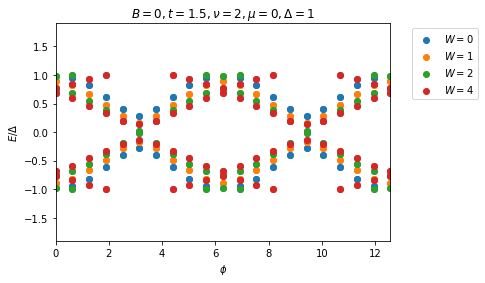

In [177]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
ex3 = []
ey3 = []
for i in range(len(e_array15)):
    for j in range(len(e_array15[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array15[i][j])
    for j in range(len(e_array16[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array16[i][j])
    for j in range(len(e_array17[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array17[i][j])
    for j in range(len(e_array18[i])):
        ex3.append(i/5.*np.pi)
        ey3.append(e_array18[i][j])
plt.scatter(ex, ey, label=r'$W=0$')
plt.scatter(ex1, ey1, label=r'$W=1$')
plt.scatter(ex2, ey2, label=r'$W=2$')
plt.scatter(ex3, ey3, label=r'$W=4$')
plt.xlim(0, 4*np.pi)
plt.ylim(2*min(ey), 2*max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$B=0, t=1.5, \nu=2, \mu=0, \Delta=1.$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('./Keselman B=0.png', dpi=300)

21
[]
[-0.95151307 -0.95151307  0.95151307  0.95151307]
[-0.8156034 -0.8156034  0.8156034  0.8156034]
[-0.61755603 -0.61755603  0.61755603  0.61755603]
[-0.40084369 -0.40084369  0.40084369  0.40084369]
[-0.27971429 -0.27971429  0.27971429  0.27971429]
[-0.40084369 -0.40084369  0.40084369  0.40084369]
[-0.61755603 -0.61755603  0.61755603  0.61755603]
[-0.8156034 -0.8156034  0.8156034  0.8156034]
[-0.95151307 -0.95151307  0.95151307  0.95151307]
[]
[-0.95151307 -0.95151307  0.95151307  0.95151307]
[-0.8156034 -0.8156034  0.8156034  0.8156034]
[-0.61755603 -0.61755603  0.61755603  0.61755603]
[-0.40084369 -0.40084369  0.40084369  0.40084369]
[-0.27971429 -0.27971429  0.27971429  0.27971429]
[-0.40084369 -0.40084369  0.40084369  0.40084369]
[-0.61755603 -0.61755603  0.61755603  0.61755603]
[-0.8156034 -0.8156034  0.8156034  0.8156034]
[-0.95151307 -0.95151307  0.95151307  0.95151307]
[]
21
[-0.88626948 -0.88626948  0.88626948  0.88626948]
[-0.81890827 -0.81890827  0.81890827  0.81890827]
[

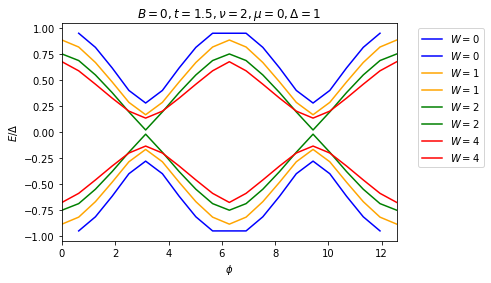

In [181]:
def extract_lowest_mode(E_array):
    Ef_array = []
    phi_array = []
    print(len(E_array))
    for i in range(len(E_array)):
        print(E_array[i])
        if len(E_array[i])!=0:
            E = np.min(np.abs(E_array[i]))
            Ef_array.append([-E, E])
            phi_array.append(np.linspace(0, 4*np.pi, 21)[i])
    return np.array(phi_array), np.array(Ef_array)

ex, ey = extract_lowest_mode(e_array15)
ex1, ey1 = extract_lowest_mode(e_array16)
ex2, ey2 = extract_lowest_mode(e_array17)
ex3, ey3 = extract_lowest_mode(e_array18)

print(extract_lowest_mode(e_array15))
print(ey)
plt.plot(ex, ey, label=r'$W=0$', color='b')
plt.plot(ex1, ey1, label=r'$W=1$', color='orange')
plt.plot(ex2, ey2, label=r'$W=2$', color='g')
plt.plot(ex3, ey3, label=r'$W=4$', color='r')
plt.xlim(0, 4*np.pi)
#plt.ylim(2*np.min(ey), 2*np.max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$B=0, t=1.5, \nu=2, \mu=0, \Delta=1.$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('./Keselman B=0.png', dpi=300)

### E_M vs W (B=0)

In [184]:
def W_scan(B=2., t=1.5, nu=2., mu=0., mu_leads=0.5, delta=1., phi=0., E_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in range(0, 11):
        print(i)
        syst = make_system_mu(W=i, B=B, t=t, nu=nu, mu=mu, mu_lead0=mu, mu_lead1=mu, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -E_range, E_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [186]:
e_array19, psi_array19 = W_scan(B=0., mu_leads=0.)
print(e_array19)
e_array20, psi_array20 = W_scan(B=0., mu_leads=0., phi=np.pi)
print(e_array20)

0
[]
1
[-0.88626948 -0.88626948  0.88626948  0.88626948]
2
[-0.98159596 -0.98159596 -0.75214712 -0.75214712  0.75214712  0.75214712
  0.98159596  0.98159596]
3
[-0.86351506 -0.86351506 -0.73688115 -0.73688115  0.73688115  0.73688115
  0.86351506  0.86351506]
4
[-0.77078466 -0.77078466 -0.67738914 -0.67738914  0.67738914  0.67738914
  0.77078466  0.77078466]
5
[-0.76736198 -0.76736198 -0.54088232 -0.54088232  0.54088232  0.54088232
  0.76736198  0.76736198]
6
[-0.68424909 -0.68424909 -0.51121182 -0.51121182  0.51121182  0.51121182
  0.68424909  0.68424909]
7
[-0.54809506 -0.54809506  0.54809506  0.54809506]
8
[-0.58055214 -0.58055214 -0.43005954 -0.43005954  0.43005954  0.43005954
  0.58055214  0.58055214]
9
[-0.55385506 -0.55385506 -0.3849396  -0.3849396   0.3849396   0.3849396
  0.55385506  0.55385506]
10
[-0.46634102 -0.46634102 -0.40905623 -0.40905623  0.40905623  0.40905623
  0.46634102  0.46634102]
[array([], dtype=float64), array([-0.88626948, -0.88626948,  0.88626948,  0.8862694

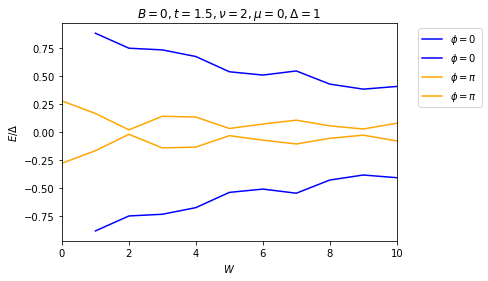

In [188]:
def extract_lowest_mode(E_array):
    Ef_array = []
    W_array = []
    #print(len(E_array))
    for i in range(len(E_array)):
        #print(E_array[i])
        if len(E_array[i])!=0:
            E = np.min(np.abs(E_array[i]))
            Ef_array.append([-E, E])
            W_array.append(range(0, 11)[i])
    return np.array(W_array), np.array(Ef_array)

ex, ey = extract_lowest_mode(e_array19)
ex1, ey1 = extract_lowest_mode(e_array20)

plt.plot(ex, ey, label=r'$\phi=0$', color='b')
plt.plot(ex1, ey1, label=r'$\phi=\pi$', color='orange')
#plt.plot(ex2, ey2, label=r'$W=2$', color='g')
#plt.plot(ex3, ey3, label=r'$W=4$', color='r')
plt.xlim(0, 10)
#plt.ylim(2*np.min(ey), 2*np.max(ey))
plt.xlabel(r'$W$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$B=0, t=1.5, \nu=2, \mu=0, \Delta=1.$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('./Keselman B=0.png', dpi=300)

## Compare to k scan

In [139]:
def k_scan(W=0, B=2., t=1.5, nu=2., mu=0., delta=1., phi=0., e_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0., 1., 11):
        print(i)
        syst = make_system(W=W, B=B, t=t, nu=nu, mu=mu, k=i, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [141]:
e_array13, psi_array13 = k_scan(rtol=1e-1)
print(e_array13)

0.0
[1.16573418e-15 1.16573418e-15]
0.1
[-0.00034409]
0.2
[-0.00144374]
0.30000000000000004
[-0.00745137]
0.4
[0.01966158]
0.5
[0.03986119]
0.6000000000000001
[-0.06951732  0.06951732]
0.7000000000000001
[-0.109632  0.109632]
0.8
[-0.86658186 -0.16060037  0.16060037  0.86658186]
0.9
[-0.84748289 -0.22209752  0.22209752  0.84748289]
1.0
[-0.82484417 -0.29299719  0.29299719  0.82484417]
[array([1.16573418e-15, 1.16573418e-15]), array([-0.00034409]), array([-0.00144374]), array([-0.00745137]), array([0.01966158]), array([0.03986119]), array([-0.06951732,  0.06951732]), array([-0.109632,  0.109632]), array([-0.86658186, -0.16060037,  0.16060037,  0.86658186]), array([-0.84748289, -0.22209752,  0.22209752,  0.84748289]), array([-0.82484417, -0.29299719,  0.29299719,  0.82484417])]


Text(0.5, 1.0, '$B=2, t=1.5, \\nu=2, \\mu=0, \\Delta=1$')

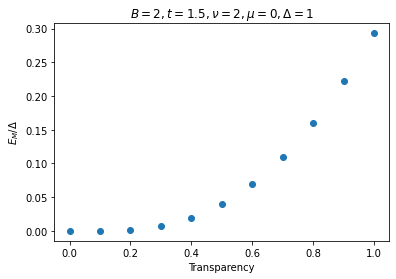

In [145]:
E_M = []
kappa = []

for i in range(11):
    if e_array13[i].size!=0:
        E_M.append(np.min(np.abs(e_array13[i])))
        kappa.append(np.linspace(0., 1., 11)[i])
    
plt.scatter(kappa, E_M)
plt.xlabel('Transparency')
plt.ylabel(r'$E_M/\Delta$')
#plt.xlim(-1.73, 1.73)
#plt.ylim(0, 0.6)
plt.title(r'$B=2, t=1.5, \nu=2, \mu=0, \Delta=1$')

## E_M vs B (to see if there's Majorana oscillations due to the finite size of the junction)

In [48]:
def B_scan(W=0, t=1.5, nu=2., mu=0., mu_leads=0., delta=1., phi=0., E_range=1., rtol=1e-2, B_range=[1, 2]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.arange(B_range[0], B_range[1], 1e-4):
        print(i)
        syst = make_system_mu(W=W, B=i, t=t, nu=nu, mu=mu, mu_lead0=mu, mu_lead1=mu_leads, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -E_range, E_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [63]:
def phi_scan(W=0, B=2., t=1.5, nu=2., mu=0., delta=1., mu_lead=0.5, e_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 4.*np.pi, 21):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=mu, mu_lead0=mu, mu_lead1=mu, delta=delta, phi=i)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [64]:
e_array42, psi_array42 = phi_scan(B=0., mu_lead=0., e_range=1.1)
print(e_array42)

0.0
[]
0.031415926535897934
[]
0.06283185307179587
[-0.99950661 -0.99950661  0.99950661  0.99950661]
0.0942477796076938
[-0.99889012 -0.99889012  0.99889012  0.99889012]
0.12566370614359174
[-0.99802749 -0.99802749  0.99802749  0.99802749]
0.15707963267948966
[-0.99691919 -0.99691919  0.99691919  0.99691919]
0.1884955592153876
[-0.9955658 -0.9955658  0.9955658  0.9955658]
0.21991148575128555
[-0.99396806 -0.99396806  0.99396806  0.99396806]
0.25132741228718347
[-0.9921268 -0.9921268  0.9921268  0.9921268]
0.2827433388230814
[-0.990043 -0.990043  0.990043  0.990043]
0.3141592653589793
[-0.98771776 -0.98771776  0.98771776  0.98771776]
0.3455751918948773
[-0.9851523 -0.9851523  0.9851523  0.9851523]
0.3769911184307752
[-0.98234797 -0.98234797  0.98234797  0.98234797]
0.4084070449666731
[-0.97930622 -0.97930622  0.97930622  0.97930622]
0.4398229715025711
[-0.97602865 -0.97602865  0.97602865  0.97602865]
0.471238898038469
[-0.97251693 -0.97251693  0.97251693  0.97251693]
0.5026548245743669


In [62]:
syst = make_system_mu(W=1, B=0., t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1., phi=0.6283185307179586)
energies, wavefunctions = find_boundstates(syst, -1.1, 1.1, rtol=1e-2)
print(energies)

[-0.81890827 -0.81890827  0.81890827  0.81890827]


In [243]:
np.arange(0, 1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [49]:
e_array21, psi_array21 = B_scan(delta=1e-3, E_range=1.1e-3, rtol=1e-5, B_range=[0, 2e-3])
print(e_array21)

0.0
[]
0.0001


RuntimeError: Found a mode with zero or close to zero velocity.

In [47]:
def B_gap_scan(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1., W=0, B_range=[1, 2]):
    band_gap_array = []
    for i in np.arange(B_range[0], B_range[1], 0.1):
        print(i)
        syst = make_system_mu(t=t, nu=nu, mu=mu, mu_lead0=mu_lead0, mu_lead1=mu_lead1, delta=delta, W=W, B=i)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,1000001)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
    return np.array(band_gap_array)

In [242]:
syst = make_system_mu(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1., W=0, B=2.)
hopping = syst.leads[0].hamiltonian(0, 1)
hopping_dag = hopping.conj().T
print(hopping)
print(hopping_dag)
print(hopping_dag - hopping)

[[-1.5-0.j  2. -0.j -0. -0.j -0. -0.j]
 [-2. -0.j -1.5-0.j -0. -0.j -0. -0.j]
 [-0. -0.j -0. -0.j  1.5-0.j -2. -0.j]
 [-0. -0.j -0. -0.j  2. -0.j  1.5-0.j]]
[[-1.5+0.j -2. +0.j -0. +0.j -0. +0.j]
 [ 2. +0.j -1.5+0.j -0. +0.j -0. +0.j]
 [-0. +0.j -0. +0.j  1.5+0.j  2. +0.j]
 [-0. +0.j -0. +0.j -2. +0.j  1.5+0.j]]
[[ 0.+0.j -4.+0.j  0.+0.j  0.+0.j]
 [ 4.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  4.+0.j]
 [ 0.+0.j  0.+0.j -4.+0.j  0.+0.j]]


0.001
0.0
[]


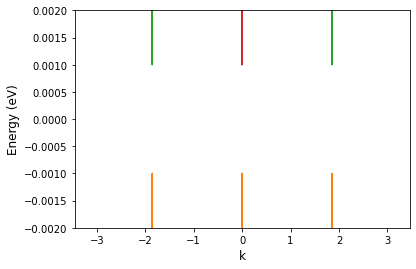

1.976558150747247
1.8865389548512859


In [42]:
syst = make_system_mu(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1e-3, W=0, B=0.)

bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,1000001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
print(np.min(en[:,2]))
print(momenta[np.argmin(en[:,2])])
print(momenta[np.where(en[:2]==1e-3)[0]])
plt.plot(momenta, en)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.ylim(-2e-3, 2e-3)
plt.show()
print(1.976558150747247)
print(1.8865389548512859)

1.5765704741710351e-06
-1.976558150747247
-0.629158


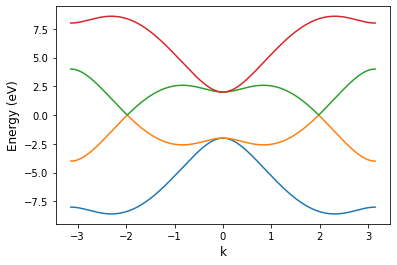

In [43]:
syst = make_system_mu(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=0., W=0, B=2.)

bands=kwant.physics.Bands(syst.leads[0])
momenta=np.linspace(-np.pi,np.pi,1000001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
print(np.min(en[:,2]))
print(momenta[np.argmin(en[:,2])])
print(momenta[np.argmin(en[:,2])]/np.pi)
plt.plot(momenta, en)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

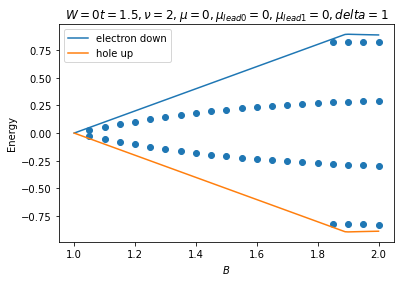

In [208]:
band_gap_array = B_gap_scan(B_range=[0, 2], res=)
#print(np.array(band_gap_array))

ex = []
ey = []
#ex1 = []
#ey1 = []
#ex2 = []
#ey2 = []
for i in range(len(e_array21)):
    for j in range(len(e_array21[i])):
        ex.append(i/20.+1.)
        ey.append(e_array21[i][j])
    '''for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])'''
plt.scatter(ex, ey)
#plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
#plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
#plt.xlim(0, 4*np.pi)
#plt.ylim(2*min(ey), 2*max(ey))
#plt.xlabel(r'$\phi$')
#plt.ylabel(r'$E/\Delta$')
#plt.title(r'$W=0, B=2, t=1.5, \nu=2, \mu=0, \mu_{lead0}=0, \mu_{lead1}=0.5, delta=1$')
#plt.legend()

plt.plot(np.linspace(1., 2, 101), band_gap_array[:,0], label='electron down')
plt.plot(np.linspace(1., 2, 101), band_gap_array[:,1], label='hole up')
plt.xlabel(r'$B$')
plt.ylabel('Energy')
plt.title(r'$W=0 t=1.5, \nu=2, \mu=0, \mu_{lead0}=0, \mu_{lead1}=0, delta=1$')
plt.legend()
#plt.xlim(0.705, 0.71)

#print('B = ' + str(np.argmin(band_gap_array[:,0])+1./100.))
#print('Band gap = ' + str(np.min(band_gap_array[:,0])*2.))

In [248]:
e_array22, psi_array22 = B_scan(B_range=[1, 5])
print(e_array22)

TypeError: B_scan() got an unexpected keyword argument 'res'

40


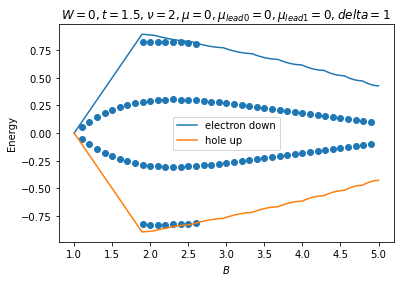

In [257]:
band_gap_array = B_gap_scan(B_range=[1, 5], res=401)
#print(np.array(band_gap_array))
print(len(e_array22))
ex = []
ey = []
#ex1 = []
#ey1 = []
#ex2 = []
#ey2 = []
for i in range(len(e_array22)):
    for j in range(len(e_array22[i])):
        ex.append(i/10.+1.)
        ey.append(e_array22[i][j])
    '''for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])'''
plt.scatter(ex, ey)
#plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
#plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
#plt.xlim(0, 4*np.pi)
#plt.ylim(2*min(ey), 2*max(ey))
#plt.xlabel(r'$\phi$')
#plt.ylabel(r'$E/\Delta$')
#plt.title(r'$W=0, B=2, t=1.5, \nu=2, \mu=0, \mu_{lead0}=0, \mu_{lead1}=0.5, delta=1$')
#plt.legend()

plt.plot(np.linspace(1., 5, 401), band_gap_array[:,0], label='electron down')
plt.plot(np.linspace(1., 5, 401), band_gap_array[:,1], label='hole up')
plt.xlabel(r'$B$')
plt.ylabel('Energy')
plt.title(r'$W=0, t=1.5, \nu=2, \mu=0, \mu_{lead0}=0, \mu_{lead1}=0, delta=1$')
plt.legend()
#plt.xlim(0.705, 0.71)

#print('B = ' + str(np.argmin(band_gap_array[:,0])+1./100.))
#print('Band gap = ' + str(np.min(band_gap_array[:,0])*2.))

## E_M vs W

In [261]:
def W_scan(B=2., t=1.5, nu=2., mu=0., mu_leads=0., delta=1., phi=0.):
    energy_arrays = []
    wavefunc_arrays = []
    for i in range(0, 101):
        print(i)
        syst = make_system_mu(W=i, B=B, t=t, nu=nu, mu=mu, mu_lead0=mu_leads, mu_lead1=mu_leads, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -1, 1, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [260]:
syst = make_system_mu(W=100, B=2., t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1., phi=0.)
energies, wavefunctions = find_boundstates(syst, -1, 1, rtol=1e-2)
print(energies)

[-0.84133824 -0.75923175 -0.73092882 -0.63234241 -0.5057638  -0.38982495
 -0.25981443 -0.16095566 -0.04579793  0.04579793  0.16095566  0.25981443
  0.38982495  0.5057638   0.63234241  0.73092882  0.75923175  0.84133824]


In [262]:
e_array23, psi_array23 = W_scan()
print(e_array23)

0
[-0.82484417 -0.29299719  0.29299719  0.82484417]
1
[-0.66311949 -0.13188976  0.13188976  0.66311949]
2
[-0.71041241 -0.3928608   0.3928608   0.71041241]
3
[-0.4038505  -0.11468791  0.11468791  0.4038505 ]
4
[-0.50601904 -0.04231066  0.04231066  0.50601904]
5
[-0.4744818  -0.18080397  0.18080397  0.4744818 ]
6
[-0.22595203  0.22595203]
7
[-0.81278036 -0.45317019 -0.08892865  0.08892865  0.45317019  0.81278036]
8
[-0.87859587 -0.31684994 -0.14175345  0.14175345  0.31684994  0.87859587]
9
[-0.83222602 -0.2584667  -0.1499279   0.1499279   0.2584667   0.83222602]
10
[-0.64739524 -0.38696189 -0.0966444   0.0966444   0.38696189  0.64739524]
11
[-0.8773062  -0.80049503 -0.21899374 -0.14520291  0.14520291  0.21899374
  0.80049503  0.8773062 ]
12
[-0.64129735 -0.27613601 -0.11443911  0.11443911  0.27613601  0.64129735]
13
[-0.57814744 -0.30395383 -0.09886145  0.09886145  0.30395383  0.57814744]
14
[-0.74515055 -0.70668367 -0.15995481  0.15995481  0.70668367  0.74515055]
15
[-0.86180907 -0.511

Text(0.5, 1.0, '$B=2., t=1.5, \\nu=2., \\mu=0., k=1, \\Delta=1.$')

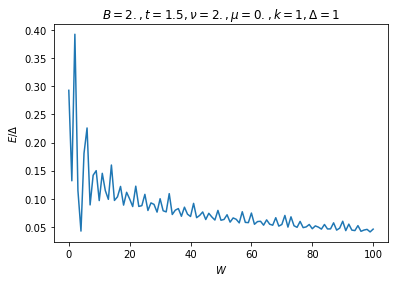

In [264]:
E_M = []
W = np.arange(0, 101)

for i in W:
    E_M.append(np.min(np.abs(e_array23[i])))
    
plt.plot(W, E_M)
plt.xlabel(r'$W$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$B=2., t=1.5, \nu=2., \mu=0., k=1, \Delta=1.$')

## Site potential barrier

## 4pi periodicity

In [8]:
def mu_scan(W=1, B=2., t=1.5, nu=2., mu_leads=0., delta=1., phi=0., e_range=1., rtol=1e-2, mu_array=[-0.2, 0.2]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.arange(mu_array[0], mu_array[1], 0.01):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=i, mu_lead0=mu_leads, mu_lead1=mu_leads, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [11]:
e_array40, psi_array40 = mu_scan(W=1, B=2., t=1.5, nu=2., mu_leads=0., delta=1e-3, phi=0., e_range=1.1e-3, rtol=1e-5, mu_array=[-0.2, 0.2])
print(e_array40)

-0.2
[-0.00036234  0.00036234]
-0.19
[-0.00036066  0.00036066]
-0.18
[-0.00035896  0.00035896]
-0.16999999999999998
[-0.00035724  0.00035724]
-0.15999999999999998
[-0.0003555  0.0003555]
-0.14999999999999997
[-0.00035373  0.00035373]
-0.13999999999999996
[-0.00035194  0.00035194]
-0.12999999999999995
[-0.00035012  0.00035012]
-0.11999999999999994
[-0.00034829  0.00034829]
-0.10999999999999993
[-0.00034643  0.00034643]
-0.09999999999999992
[-0.00034454  0.00034454]
-0.08999999999999991
[-0.00034263  0.00034263]
-0.0799999999999999
[-0.0003407  0.0003407]
-0.0699999999999999
[-0.00033874  0.00033874]
-0.05999999999999989
[-0.00033676  0.00033676]
-0.04999999999999988
[-0.00033475  0.00033475]
-0.03999999999999987
[-0.00033272  0.00033272]
-0.02999999999999986
[-0.00033066  0.00033066]
-0.01999999999999985
[-0.00032857  0.00032857]
-0.009999999999999842
[-0.00032646  0.00032646]
1.6653345369377348e-16
[-0.00032432  0.00032432]
0.010000000000000175
[-0.00032216  0.00032216]
0.0200000000000

In [ ]:
def B_gap_scan(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1., W=0, B_range=[1, 2], res=101):
    band_gap_array = []
    for i in np.linspace(B_range[0], B_range[1], res):
        syst = make_system_mu(t=t, nu=nu, mu=mu, mu_lead0=mu_lead0, mu_lead1=mu_lead1, delta=delta, W=W, B=i)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,101)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
    return np.array(band_gap_array)

In [23]:
def gap_calc(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=1., W=1, B=2.):
    syst = make_system_mu(t=t, nu=nu, mu=mu, mu_lead0=mu_lead0, mu_lead1=mu_lead1, delta=delta, W=W, B=B)
    bands=kwant.physics.Bands(syst.leads[1])
    momenta=np.linspace(-np.pi,np.pi,100001)
    energies=[bands(k) for k in momenta]
    x=np.array(energies)
    en=(x)
    return np.min(en[:,2])

gap_trial = gap_calc(delta=1e-3)
print(gap_trial)

0.0008787973516127653


(40,)
40


Text(0.5, 1.0, '$B=2, t=1.5, \\nu=2, \\mu_{leads}=0, \\Delta=1e-3$')

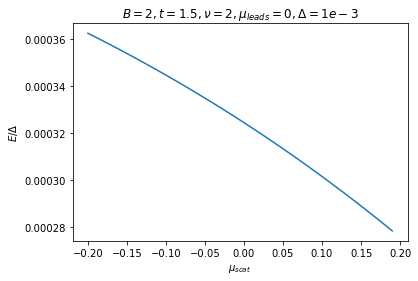

In [13]:
E_M = []
mu = np.arange(-0.2, 0.2, 0.01)

for i in range(len(e_array40)):
    E_M.append(np.min(np.abs(e_array40[i])))
    
    
print(mu.shape)
print(len(E_M))
plt.plot(mu, E_M)
plt.xlabel(r'$\mu_{scat}$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$B=2, t=1.5, \nu=2, \mu_{leads}=0, \Delta=1e-3$')

In [ ]:
e_array41, psi_array41 = phi_scan(mu=0.2, delta=1e-3, e_range=1.1e-3, rtol=1e-5)

In [9]:
def phi_scan(W=1, B=2., t=1.5, nu=2., mu=0.5, delta=1., mu_lead=0., e_range=1., rtol=1e-2):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 4*np.pi, 21):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=mu, mu_lead0=mu_lead, mu_lead1=mu_lead, delta=delta, phi=i)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [9]:
e_array24, psi_array24 = phi_scan()
print(e_array24)

0.0
[-0.68498638  0.68498638]
0.6283185307179586
[-0.67718938  0.67718938]
1.2566370614359172
[-0.65930308  0.65930308]
1.8849555921538759
[-0.64261198  0.64261198]
2.5132741228718345
[-0.6341006  0.6341006]
3.141592653589793
[-6.32196387e-01  3.40005801e-16  3.40005801e-16  6.32196387e-01]
3.7699111843077517
[-0.6341006  0.6341006]
4.39822971502571
[-0.64261198  0.64261198]
5.026548245743669
[-0.65930308  0.65930308]
5.654866776461628
[-0.67718938  0.67718938]
6.283185307179586
[-0.68498638  0.68498638]
6.911503837897545
[-0.67718938  0.67718938]
7.5398223686155035
[-0.65930308  0.65930308]
8.168140899333462
[-0.64261198  0.64261198]
8.79645943005142
[-0.6341006  0.6341006]
9.42477796076938
[-6.32196387e-01  3.47812057e-16  3.47812057e-16  6.32196387e-01]
10.053096491487338
[-0.6341006  0.6341006]
10.681415022205297
[-0.64261198  0.64261198]
11.309733552923255
[-0.65930308  0.65930308]
11.938052083641214
[-0.67718938  0.67718938]
12.566370614359172
[-0.68498638  0.68498638]
[array([-0

In [13]:
e_array25, psi_array25 = phi_scan(e_range=1e-2, rtol=1e-4)
print(e_array25)

0.0
[-0.00169674  0.00169674]
0.6283185307179586
[-0.00163968  0.00163968]
1.2566370614359172
[-0.00145275  0.00145275]
1.8849555921538759
[-0.00110651  0.00110651]
2.5132741228718345
[-0.00060226  0.00060226]
3.141592653589793
[5.89365525e-16 5.89365525e-16]
3.7699111843077517
[-0.00060226  0.00060226]
4.39822971502571
[-0.00110651  0.00110651]
5.026548245743669
[-0.00145275  0.00145275]
5.654866776461628
[-0.00163968  0.00163968]
6.283185307179586
[-0.00169674  0.00169674]
6.911503837897545
[-0.00163968  0.00163968]
7.5398223686155035
[-0.00145275  0.00145275]
8.168140899333462
[-0.00110651  0.00110651]
8.79645943005142
[-0.00060226  0.00060226]
9.42477796076938
[5.92245437e-16 5.92245437e-16]
10.053096491487338
[-0.00060226  0.00060226]
10.681415022205297
[-0.00110651  0.00110651]
11.309733552923255
[-0.00145275  0.00145275]
11.938052083641214
[-0.00163968  0.00163968]
12.566370614359172
[-0.00169674  0.00169674]
[array([-0.00169674,  0.00169674]), array([-0.00163968,  0.00163968]),

In [16]:
e_array26, psi_array26 = phi_scan(mu=0.1)
print(e_array26)

0.0
[-0.6664154  -0.10598681  0.10598681  0.6664154 ]
0.6283185307179586
[-0.65929408 -0.1023742   0.1023742   0.65929408]
1.2566370614359172
[-0.64339087 -0.09054038  0.09054038  0.64339087]
1.8849555921538759
[-0.62966362 -0.06872441  0.06872441  0.62966362]
2.5132741228718345
[-0.62399455 -0.0372642   0.0372642   0.62399455]
3.141592653589793
[-6.23275433e-01  3.74700271e-16  3.74700271e-16  6.23275433e-01]
3.7699111843077517
[-0.62399455 -0.0372642   0.0372642   0.62399455]
4.39822971502571
[-0.62966362 -0.06872441  0.06872441  0.62966362]
5.026548245743669
[-0.64339087 -0.09054038  0.09054038  0.64339087]
5.654866776461628
[-0.65929408 -0.1023742   0.1023742   0.65929408]
6.283185307179586
[-0.6664154  -0.10598681  0.10598681  0.6664154 ]
6.911503837897545
[-0.65929408 -0.1023742   0.1023742   0.65929408]
7.5398223686155035
[-0.64339087 -0.09054038  0.09054038  0.64339087]
8.168140899333462
[-0.62966362 -0.06872441  0.06872441  0.62966362]
8.79645943005142
[-0.62399455 -0.0372642 

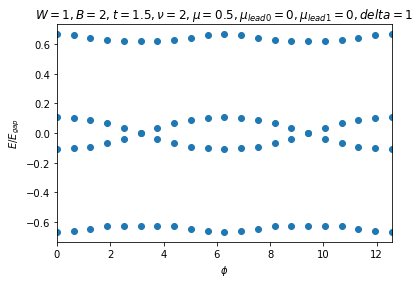

In [37]:
ex = []
ey = []
#ex1 = []
#ey1 = []
#ex2 = []
#ey2 = []
for i in range(len(e_array26)):
    for j in range(len(e_array26[i])):
        ex.append(i/5.*np.pi)
        ey.append(e_array26[i][j])
    '''for j in range(len(e_array1[i])):
        ex1.append(i/5.*np.pi)
        ey1.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex2.append(i/5.*np.pi)
        ey2.append(e_array2[i][j])'''
plt.scatter(ex, ey)
#plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
#plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
plt.xlim(0, 4*np.pi)
#plt.ylim(2*min(ey), 2*max(ey))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E/E_{gap}$')
plt.title(r'$W=1, B=2, t=1.5, \nu=2, \mu=0.5, \mu_{lead0}=0, \mu_{lead1}=0, delta=1$')
#plt.legend()

def phi_plot(energy_array, title=r'$W=1, B=2, t=1.5, \nu=2, \mu=0.5, \mu_{lead0}=0, \mu_{lead1}=0, delta=1$'):
    ex = []
    ey = []
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(i/5.*np.pi)
            ey.append(energy_array[i][j])
            
    plt.scatter(ex, ey)
    #plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
    #plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
    plt.xlim(0, 4*np.pi)
    #plt.ylim(2*min(ey), 2*max(ey))
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)

In [65]:
def phi_plot(energy_array, title=r'$W=1, B=2, t=1.5, \nu=2, \mu=0.5, \mu_{lead0}=0, \mu_{lead1}=0, delta=1$'):
    ex = []
    ey = []
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(i/5.*np.pi)
            ey.append(energy_array[i][j])
            
    plt.scatter(ex, ey)
    #plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
    #plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
    plt.xlim(0, 4*np.pi)
    #plt.ylim(2*min(ey), 2*max(ey))
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)

In [20]:
e_array27, psi_array27 = mu_scan()
print(e_array27)

-0.2
[-0.65872868 -0.18244012  0.18244012  0.65872868]
-0.19
[-0.65886893 -0.17996861  0.17996861  0.65886893]
-0.18000000000000002
[-0.65901821 -0.17749008  0.17749008  0.65901821]
-0.17
[-0.6591764  -0.17500472  0.17500472  0.6591764 ]
-0.16
[-0.65934338 -0.17251272  0.17251272  0.65934338]
-0.15000000000000002
[-0.65951903 -0.17001428  0.17001428  0.65951903]
-0.14
[-0.65970324 -0.16750958  0.16750958  0.65970324]
-0.13
[-0.6598959  -0.16499882  0.16499882  0.6598959 ]
-0.12000000000000001
[-0.66009689 -0.16248217  0.16248217  0.66009689]
-0.11000000000000001
[-0.6603061  -0.15995984  0.15995984  0.6603061 ]
-0.1
[-0.66052342 -0.15743199  0.15743199  0.66052342]
-0.09000000000000001
[-0.66074875 -0.15489881  0.15489881  0.66074875]
-0.08000000000000002
[-0.66098197 -0.15236049  0.15236049  0.66098197]
-0.07
[-0.66122298 -0.1498172   0.1498172   0.66122298]
-0.06
[-0.66147167 -0.14726912  0.14726912  0.66147167]
-0.05000000000000002
[-0.66172794 -0.14471642  0.14471642  0.66172794]
-

NameError: name 'e_array' is not defined

In [26]:
e_array28, psi_array28 = mu_scan(mu_array=[-3.5, 0.2])
print(e_array28)

-3.5
[-0.35077191  0.35077191]
-3.49
[-0.35107853  0.35107853]
-3.4800000000000004
[-0.35138505  0.35138505]
-3.4700000000000006
[-0.35169147  0.35169147]
-3.460000000000001
[-0.35199778  0.35199778]
-3.450000000000001
[-0.35230397  0.35230397]
-3.4400000000000013
[-0.35261003  0.35261003]
-3.4300000000000015
[-0.35291595  0.35291595]
-3.4200000000000017
[-0.35322173  0.35322173]
-3.410000000000002
[-0.35352735  0.35352735]
-3.400000000000002
[-0.35383282  0.35383282]
-3.3900000000000023
[-0.3541381  0.3541381]
-3.3800000000000026
[-0.35444321  0.35444321]
-3.3700000000000028
[-0.35474813  0.35474813]
-3.360000000000003
[-0.35505285  0.35505285]
-3.350000000000003
[-0.35535736  0.35535736]
-3.3400000000000034
[-0.35566165  0.35566165]
-3.3300000000000036
[-0.35596571  0.35596571]
-3.320000000000004
[-0.35626954  0.35626954]
-3.310000000000004
[-0.35657311  0.35657311]
-3.3000000000000043
[-0.35687643  0.35687643]
-3.2900000000000045
[-0.35717947  0.35717947]
-3.2800000000000047
[-0.357

(701,)
701


Text(0.5, 1.0, '$B=2, t=1.5, \\nu=2, \\mu_{leads}=0, \\Delta=1$')

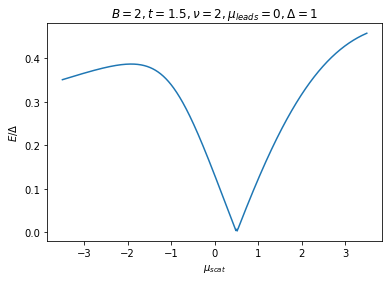

In [55]:
E_M = []
mu = np.arange(-3.5, 3.51, 0.01)

for i in range(len(e_array28)):
    E_M.append(np.min(np.abs(e_array28[i])))
    
for i in range(len(e_array32)):
    j=0
    if len(e_array32[i])!=2:
        E_M.append(np.min(np.abs(e_array32[i])))
    else:
        E_M.append(np.min(np.abs(e_array33[j])))
        j+=1
    
print(mu.shape)
print(len(E_M))
plt.plot(mu, E_M)
plt.xlabel(r'$\mu_{scat}$')
plt.ylabel(r'$E/\Delta$')
plt.title(r'$B=2, t=1.5, \nu=2, \mu_{leads}=0, \Delta=1$')

In [34]:
e_array29, psi_array29 = phi_scan(mu=-3.5)
print(e_array29)

0.0
[-0.35077191  0.35077191]
0.6283185307179586
[-0.33297974  0.33297974]
1.2566370614359172
[-0.28189748  0.28189748]
1.8849555921538759
[-0.20364804  0.20364804]
2.5132741228718345
[-0.10658994  0.10658994]
3.141592653589793
[-1.81018395e-15 -1.81018395e-15]
3.7699111843077517
[-0.10658994  0.10658994]
4.39822971502571
[-0.20364804  0.20364804]
5.026548245743669
[-0.28189748  0.28189748]
5.654866776461628
[-0.33297974  0.33297974]
6.283185307179586
[-0.35077191  0.35077191]
6.911503837897545
[-0.33297974  0.33297974]
7.5398223686155035
[-0.28189748  0.28189748]
8.168140899333462
[-0.20364804  0.20364804]
8.79645943005142
[-0.10658994  0.10658994]
9.42477796076938
[-1.79196935e-15 -1.79196935e-15]
10.053096491487338
[-0.10658994  0.10658994]
10.681415022205297
[-0.20364804  0.20364804]
11.309733552923255
[-0.28189748  0.28189748]
11.938052083641214
[-0.33297974  0.33297974]
12.566370614359172
[-0.35077191  0.35077191]
[array([-0.35077191,  0.35077191]), array([-0.33297974,  0.3329797

In [35]:
e_array30, psi_array30 = phi_scan(mu=3.5)
print(e_array30)

0.0
[-0.86840894 -0.45743167  0.45743167  0.86840894]
0.6283185307179586
[-0.87016115 -0.43428027  0.43428027  0.87016115]
1.2566370614359172
[-0.87472349 -0.36755534  0.36755534  0.87472349]
1.8849555921538759
[-0.87852604 -0.26522588  0.26522588  0.87852604]
2.5132741228718345
[-0.13863576  0.13863576]
3.141592653589793
[1.14960125e-14 1.14960125e-14]
3.7699111843077517
[-0.13863576  0.13863576]
4.39822971502571
[-0.87852604 -0.26522588  0.26522588  0.87852604]
5.026548245743669
[-0.87472349 -0.36755534  0.36755534  0.87472349]
5.654866776461628
[-0.87016115 -0.43428027  0.43428027  0.87016115]
6.283185307179586
[-0.86840894 -0.45743167  0.45743167  0.86840894]
6.911503837897545
[-0.87016115 -0.43428027  0.43428027  0.87016115]
7.5398223686155035
[-0.87472349 -0.36755534  0.36755534  0.87472349]
8.168140899333462
[-0.87852604 -0.26522588  0.26522588  0.87852604]
8.79645943005142
[-0.13863576  0.13863576]
9.42477796076938
[1.15307069e-14 1.15307069e-14]
10.053096491487338
[-0.13863576

In [39]:
e_array31, psi_array31 = phi_scan(mu=1.)
print(e_array31)

0.0
[-0.71607101 -0.12189079  0.12189079  0.71607101]
0.6283185307179586
[-0.70916813 -0.11754204  0.11754204  0.70916813]
1.2566370614359172
[-0.69410356 -0.10349741  0.10349741  0.69410356]
1.8849555921538759
[-0.68183002 -0.07813196  0.07813196  0.68183002]
2.5132741228718345
[-0.67758003 -0.04218796  0.04218796  0.67758003]
3.141592653589793
[-6.77445417e-01  2.70616862e-16  2.70616862e-16  6.77445417e-01]
3.7699111843077517
[-0.67758003 -0.04218796  0.04218796  0.67758003]
4.39822971502571
[-0.68183002 -0.07813196  0.07813196  0.68183002]
5.026548245743669
[-0.69410356 -0.10349741  0.10349741  0.69410356]
5.654866776461628
[-0.70916813 -0.11754204  0.11754204  0.70916813]
6.283185307179586
[-0.71607101 -0.12189079  0.12189079  0.71607101]
6.911503837897545
[-0.70916813 -0.11754204  0.11754204  0.70916813]
7.5398223686155035
[-0.69410356 -0.10349741  0.10349741  0.69410356]
8.168140899333462
[-0.68183002 -0.07813196  0.07813196  0.68183002]
8.79645943005142
[-0.67758003 -0.04218796

In [49]:
e_array32, psi_array32 = mu_scan(mu_array=[0.2, 3.51])
print(e_array32)

0.2
[-0.67032237 -0.07988062  0.07988062  0.67032237]
0.21000000000000002
[-0.67074361 -0.07726443  0.07726443  0.67074361]
0.22000000000000003
[-0.67117011 -0.07464778  0.07464778  0.67117011]
0.23000000000000004
[-0.6716018  -0.07203079  0.07203079  0.6716018 ]
0.24000000000000005
[-0.67203861 -0.06941361  0.06941361  0.67203861]
0.25000000000000006
[-0.67248046 -0.06679636  0.06679636  0.67248046]
0.26000000000000006
[-0.6729273  -0.06417917  0.06417917  0.6729273 ]
0.2700000000000001
[-0.67337906 -0.06156217  0.06156217  0.67337906]
0.2800000000000001
[-0.67383567 -0.05894548  0.05894548  0.67383567]
0.2900000000000001
[-0.67429706 -0.05632923  0.05632923  0.67429706]
0.3000000000000001
[-0.67476318 -0.05371354  0.05371354  0.67476318]
0.3100000000000001
[-0.67523396 -0.05109853  0.05109853  0.67523396]
0.3200000000000001
[-0.67570934 -0.04848433  0.04848433  0.67570934]
0.3300000000000001
[-0.67618925 -0.04587106  0.04587106  0.67618925]
0.34000000000000014
[-0.67667364 -0.0432588

In [53]:
e_array33, psi_array33 = mu_scan(mu_array=[0.48, 0.54], e_range=0.01, rtol=1e-4)

0.48
[-0.00686041  0.00686041]
0.49
[-0.00427719  0.00427719]
0.5
[-0.00169674  0.00169674]
0.51
[-0.00088084  0.00088084]
0.52
[-0.00345545  0.00345545]
0.53
[-0.006027  0.006027]
0.54
[-0.00859539  0.00859539]


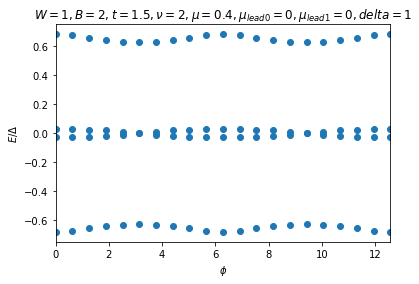

In [45]:
phi_plot(e_array32, title=r'$W=1, B=2, t=1.5, \nu=2, \mu=0.4, \mu_{lead0}=0, \mu_{lead1}=0, delta=1$')